In [18]:
from dynamic_pricing.db.db_utils import get_db_connection, load_order_data
import pandas as pd
import matplotlib.pyplot as plt
import itertools

In [19]:
conn = get_db_connection()

df: pd.DataFrame = load_order_data(conn,"nostimo")
print(df.info)

2024-04-03 02:29:23,103 INFO sqlalchemy.engine.Engine select pg_catalog.version()
2024-04-03 02:29:23,105 INFO sqlalchemy.engine.Engine [raw sql] {}
2024-04-03 02:29:23,296 INFO sqlalchemy.engine.Engine select current_schema()
2024-04-03 02:29:23,296 INFO sqlalchemy.engine.Engine [raw sql] {}
2024-04-03 02:29:23,486 INFO sqlalchemy.engine.Engine show standard_conforming_strings
2024-04-03 02:29:23,487 INFO sqlalchemy.engine.Engine [raw sql] {}
2024-04-03 02:29:24,362 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2024-04-03 02:29:24,364 INFO sqlalchemy.engine.Engine SELECT pg_catalog.pg_class.relname 
FROM pg_catalog.pg_class JOIN pg_catalog.pg_namespace ON pg_catalog.pg_namespace.oid = pg_catalog.pg_class.relnamespace 
WHERE pg_catalog.pg_class.relname = %(table_name)s AND pg_catalog.pg_class.relkind = ANY (ARRAY[%(param_1)s, %(param_2)s, %(param_3)s, %(param_4)s, %(param_5)s]) AND pg_catalog.pg_table_is_visible(pg_catalog.pg_class.oid) AND pg_catalog.pg_namespace.nspname != %(nspname

In [20]:
print(df.columns)
df.head()
df.fillna(0, inplace=True)

exclusion_categories = [
    "Desserts",
    "Soft Drinks",
    "Starters and Sharers",
    "Handmade Single Grills",
]

for category in exclusion_categories:
    df = df[~df["item_operational_name"].str.contains(category)]


Index(['order_id', 'deliveroo_order_id', 'deliveroo_order_number',
       'order_status', 'order_placed_timestamp', 'order_updated_timestamp',
       'order_prepare_for_timestamp', 'order_start_prepping_at_timestamp',
       'customer_id', 'first_name', 'contact_number', 'contact_access_code',
       'partner_id', 'partner_name', 'item_id', 'deliveroo_item_id',
       'item_name', 'item_operational_name', 'item_fractional_cost',
       'item_quantity', 'item_fractional_price', 'modifier_id',
       'deliveroo_modifier_id', 'modifier_name', 'modifier_operational_name',
       'modifier_quantity', 'modifier_fractional_price'],
      dtype='object')


/tmp/ipykernel_108024/1064325183.py:3: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.fillna(0, inplace=True)


Filter to keep only the items we are analyzing

In [21]:
post_dp_df = df[
    (df["order_placed_timestamp"] >= "2023-8-07")
    & (df["order_placed_timestamp"] < "2024-3-26")
]
all_items_post_dp_df = post_dp_df.copy()

post_dp_df = post_dp_df[~post_dp_df["item_operational_name"].str.contains("Wrap")]

post_dp_df.info()

interval = 30 #signifies 30 minutes

<class 'pandas.core.frame.DataFrame'>
Index: 1081 entries, 550 to 5399
Data columns (total 27 columns):
 #   Column                             Non-Null Count  Dtype         
---  ------                             --------------  -----         
 0   order_id                           1081 non-null   int64         
 1   deliveroo_order_id                 1081 non-null   object        
 2   deliveroo_order_number             1081 non-null   int64         
 3   order_status                       1081 non-null   object        
 4   order_placed_timestamp             1081 non-null   datetime64[ns]
 5   order_updated_timestamp            1081 non-null   datetime64[ns]
 6   order_prepare_for_timestamp        1081 non-null   datetime64[ns]
 7   order_start_prepping_at_timestamp  1081 non-null   datetime64[ns]
 8   customer_id                        1081 non-null   int64         
 9   first_name                         1081 non-null   int64         
 10  contact_number                     1081

In [22]:
from dynamic_pricing.analysis.utils import split_weekdays_and_weekends

post_dp_df_weekdays, post_dp_df_weekends = split_weekdays_and_weekends(
    post_dp_df, "order_placed_timestamp"
)

analysis

/home/sree/Desktop/UCL/FYP/dynamic_pricing/venv/lib/python3.10/site-packages/dynamic_pricing/analysis/utils.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, "interval_index"] = (


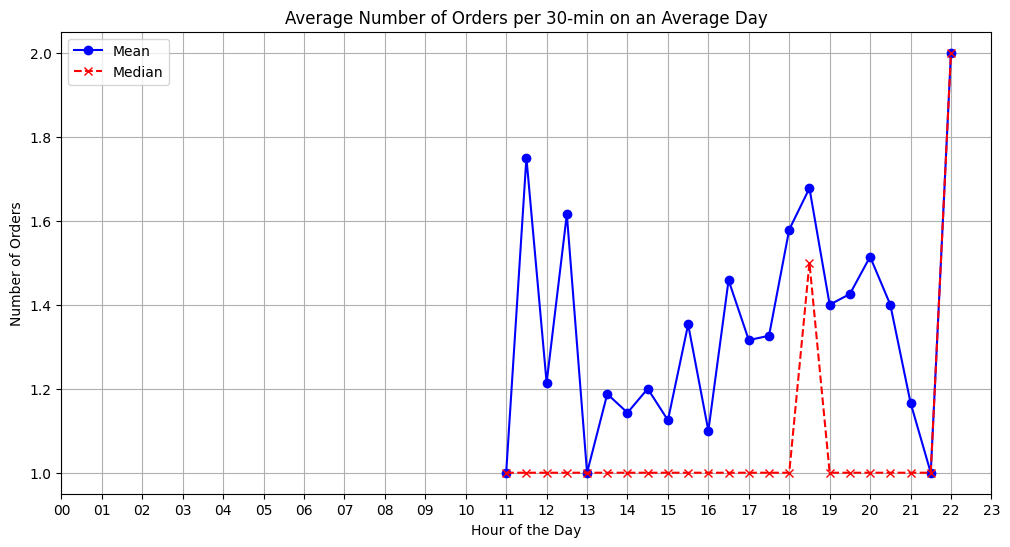

/home/sree/Desktop/UCL/FYP/dynamic_pricing/venv/lib/python3.10/site-packages/dynamic_pricing/analysis/utils.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, "interval_index"] = (


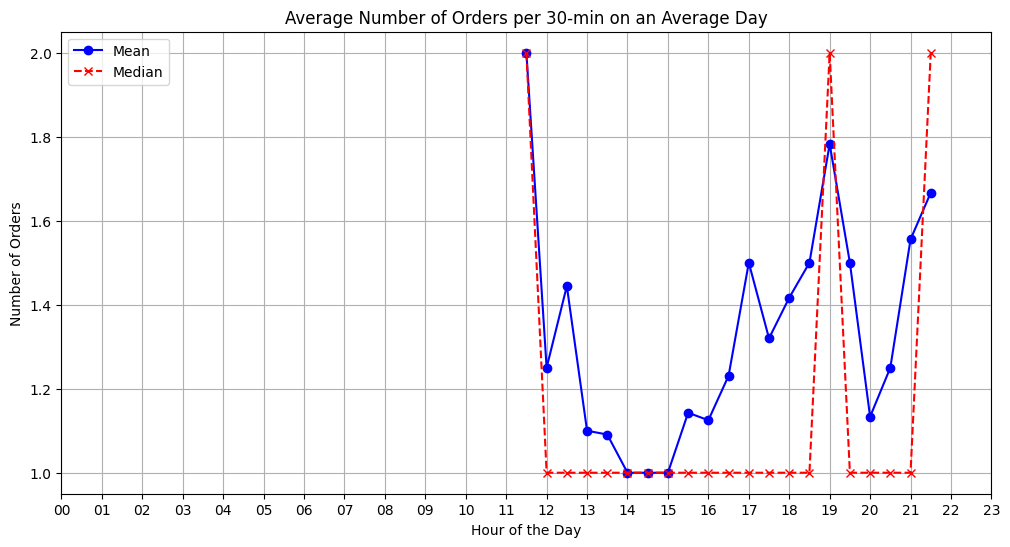

In [23]:
from dynamic_pricing.analysis.utils import plot_average_orders_per_interval

plot_average_orders_per_interval(post_dp_df_weekdays, interval=interval)
plot_average_orders_per_interval(post_dp_df_weekends, interval=interval)

     order_id  item_quantity  item_fractional_price  \
550       478              1                   1990   
570       496              1                   1650   
582       504              1                   1770   
601       514              1                   1800   
629       532              2                   1950   

     modifier_fractional_price  modifier_quantity order_placed_timestamp  \
550                          0                  0    2023-08-07 16:38:58   
570                          0                  0    2023-08-09 17:20:17   
582                          0                  0    2023-08-10 17:38:47   
601                          0                  0    2023-08-11 14:45:49   
629                          0                  0    2023-08-29 15:33:04   

     order_value  revenue  
550         19.9     19.9  
570         16.5     16.5  
582         17.7     17.7  
601         18.0     18.0  
629         39.0     39.0  


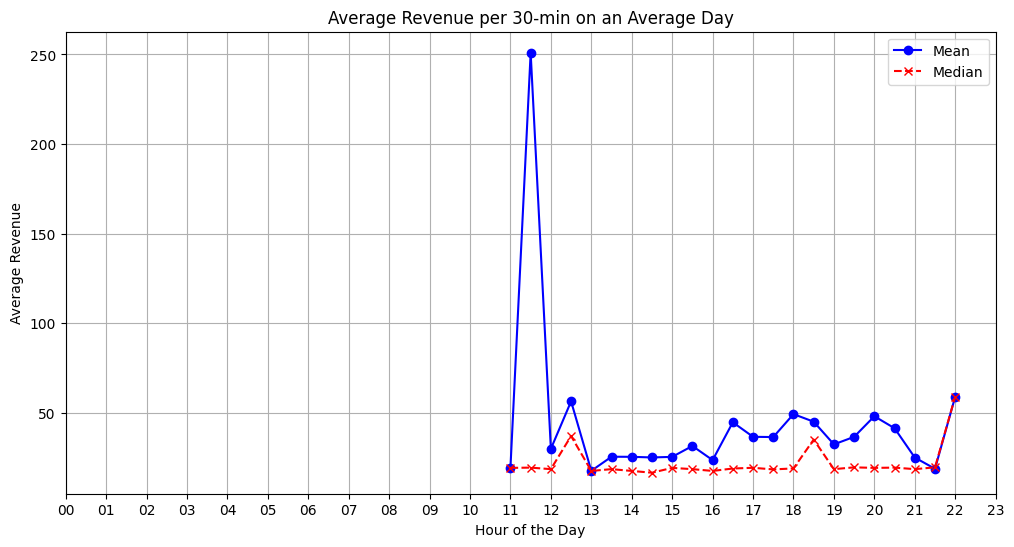

     order_id  item_quantity  item_fractional_price  \
605       518              1                   3400   
618       524              1                   1850   
619       524              1                   1850   
620       526              1                   1850   
665       566              1                   1700   

     modifier_fractional_price  modifier_quantity order_placed_timestamp  \
605                          0                  0    2023-08-12 13:54:04   
618                          0                  0    2023-08-12 18:05:40   
619                          0                  0    2023-08-12 18:05:40   
620                          0                  0    2023-08-12 18:56:21   
665                          0                  0    2023-09-02 16:54:03   

     order_value  revenue  
605         34.0     34.0  
618         18.5     37.0  
619         18.5     37.0  
620         18.5     18.5  
665         17.0     17.0  


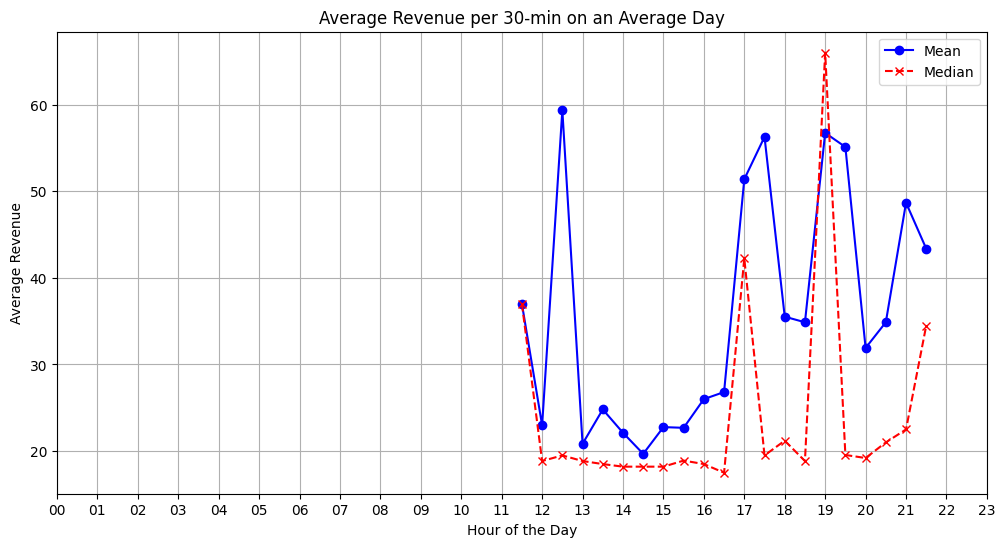

In [24]:
from dynamic_pricing.analysis.utils import plot_average_revenue_per_interval

plot_average_revenue_per_interval(post_dp_df_weekdays, interval)
plot_average_revenue_per_interval(post_dp_df_weekends, interval)

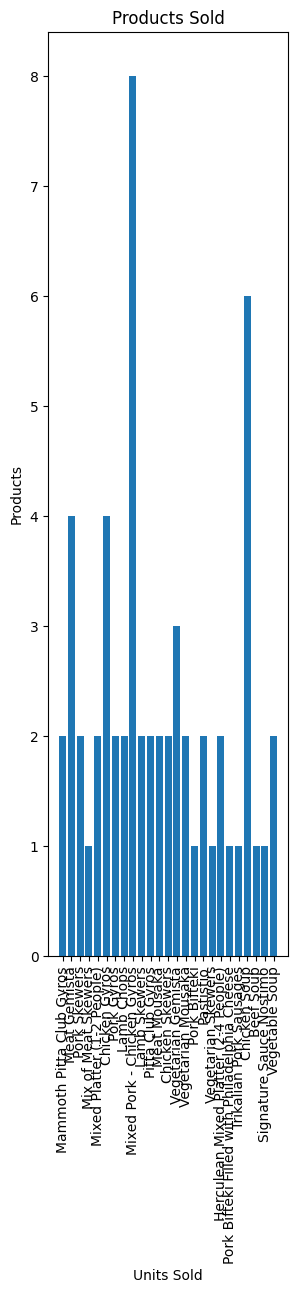

In [25]:
from dynamic_pricing.analysis.utils import plot_items_sold

plot_items_sold(post_dp_df)

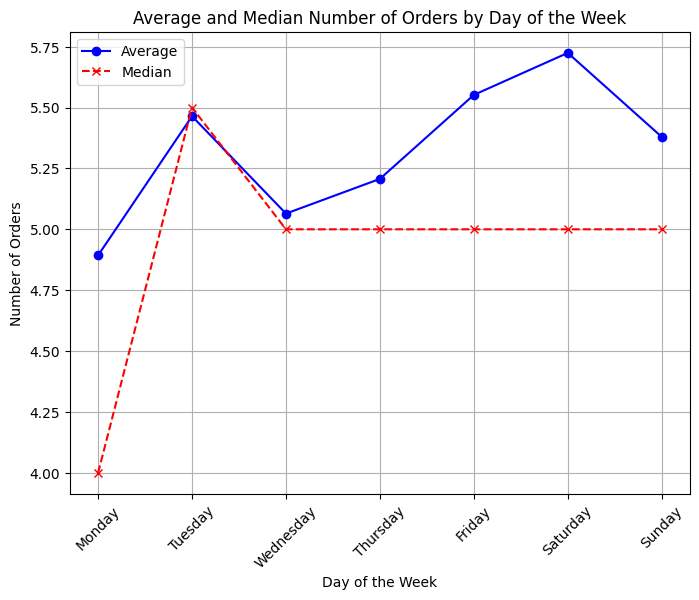

In [26]:
from dynamic_pricing.analysis.utils import plot_average_orders_by_day_of_week
plot_average_orders_by_day_of_week(post_dp_df)

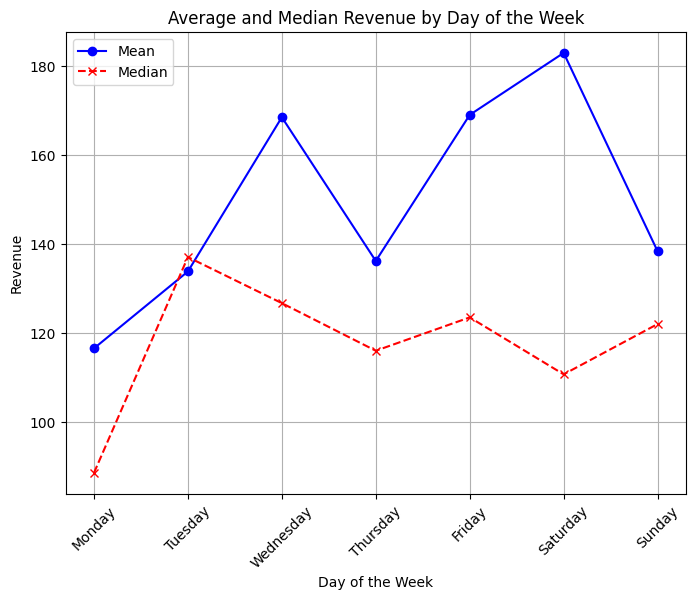

In [27]:
from dynamic_pricing.analysis.utils import plot_average_revenue_by_day_of_week

plot_average_revenue_by_day_of_week(post_dp_df)

/home/sree/Desktop/UCL/FYP/dynamic_pricing/venv/lib/python3.10/site-packages/dynamic_pricing/analysis/utils.py:306: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, "time_difference"] = (


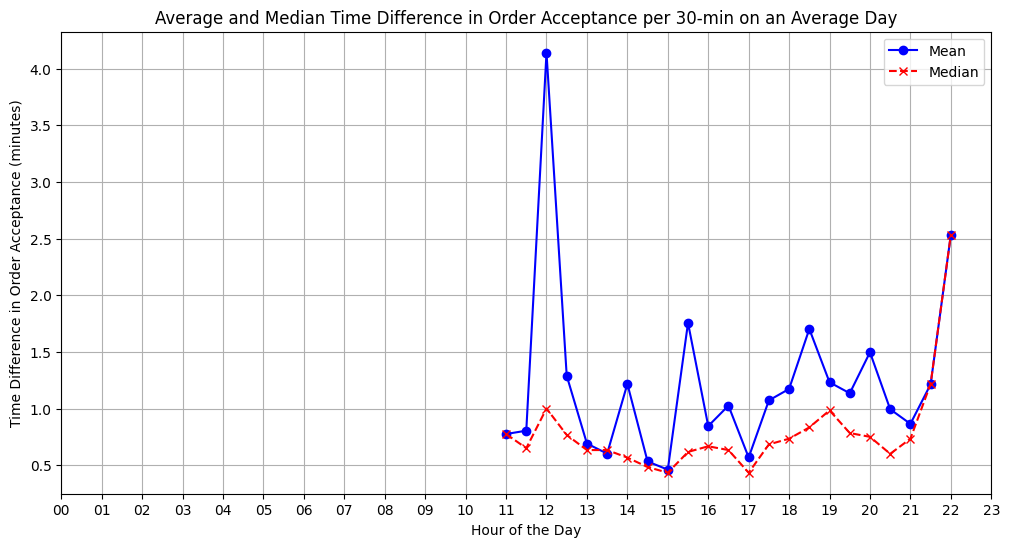

/home/sree/Desktop/UCL/FYP/dynamic_pricing/venv/lib/python3.10/site-packages/dynamic_pricing/analysis/utils.py:306: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, "time_difference"] = (


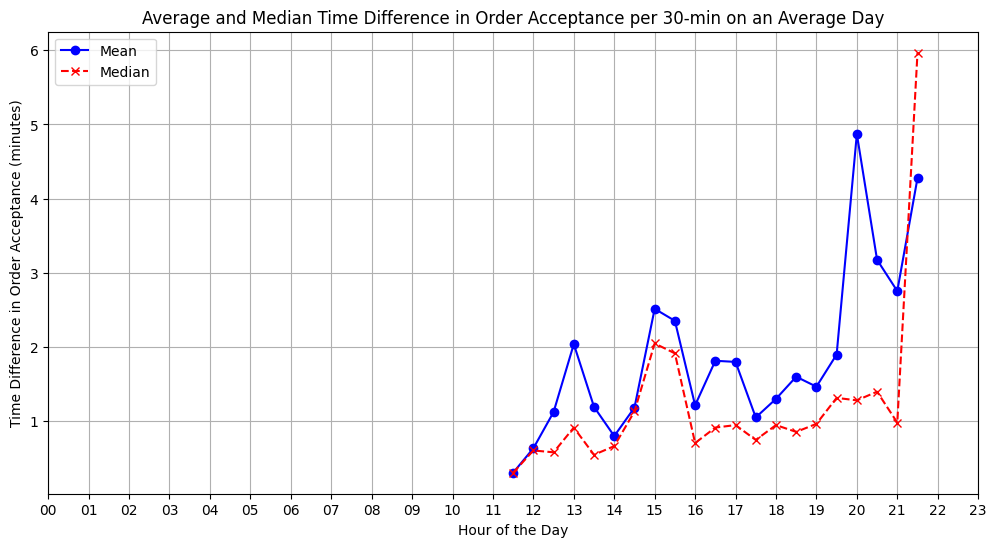

In [28]:
from dynamic_pricing.analysis.utils import time_difference_in_order_acceptance_per_interval

time_difference_in_order_acceptance_per_interval(post_dp_df_weekdays, interval)
time_difference_in_order_acceptance_per_interval(post_dp_df_weekends, interval)

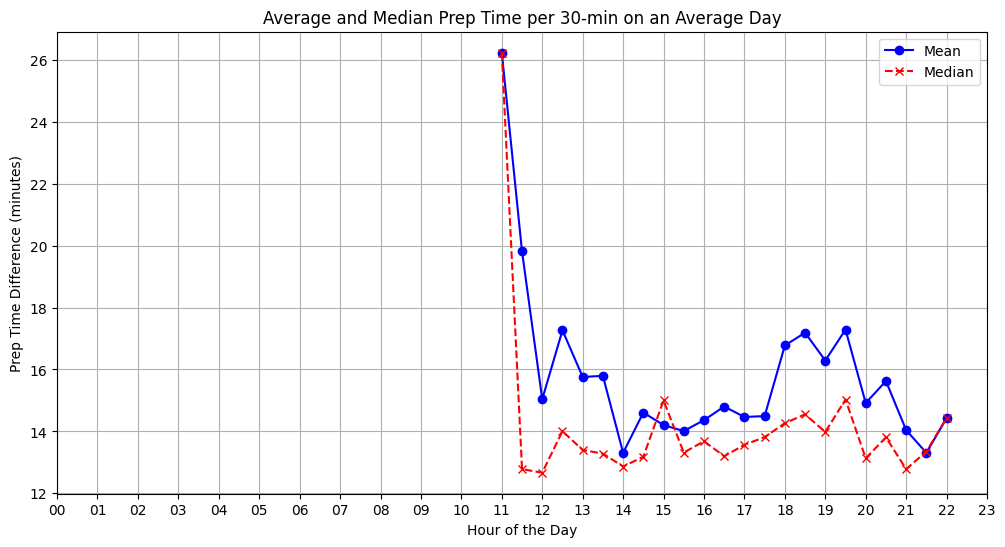

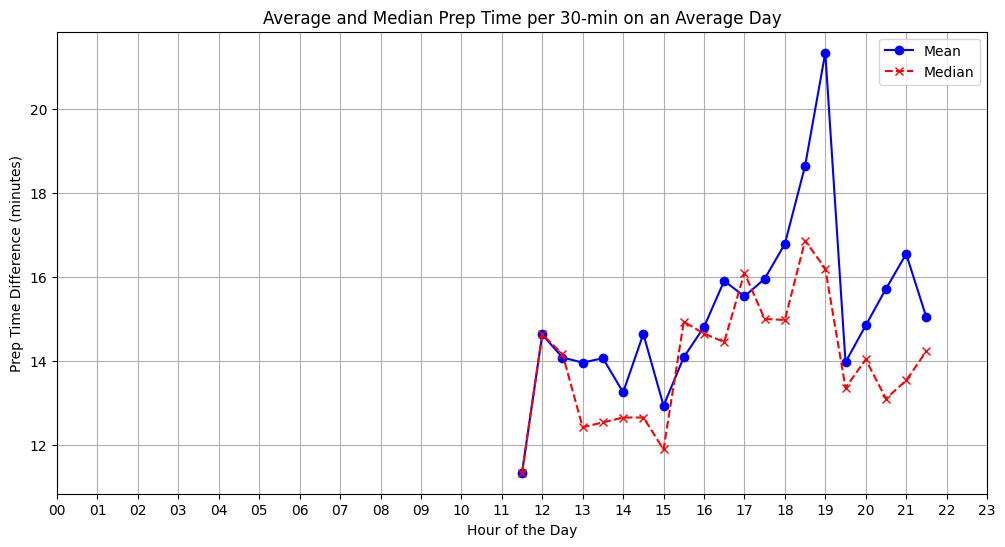

In [29]:
from dynamic_pricing.analysis.utils import prep_time_per_interval

prep_time_per_interval(post_dp_df_weekdays, interval)
prep_time_per_interval(post_dp_df_weekends, interval)

Manage outliers

In [30]:
#!TODO: manage outliers

In [31]:
from dynamic_pricing.analysis.utils import calculate_revenue_by_day_period

time_intervals = ["00:00", "14:00", "18:45", "23:59:59"]
post_dp_df_weekday_revenue = calculate_revenue_by_day_period(
    post_dp_df_weekdays, time_intervals=time_intervals
)
post_dp_df_weekend_revenue = calculate_revenue_by_day_period(
    post_dp_df_weekends, time_intervals=time_intervals
)

print(post_dp_df_weekday_revenue, post_dp_df_weekday_revenue.sum())
print(post_dp_df_weekend_revenue, post_dp_df_weekend_revenue.sum())

interval_label
00:00:00 to 14:00:00    1644.8
14:00:00 to 18:45:00    7483.8
18:45:00 to 23:59:59    6240.3
Name: order_value, dtype: float64 15368.900000000001
interval_label
00:00:00 to 14:00:00     850.0
14:00:00 to 18:45:00    3389.1
18:45:00 to 23:59:59    2511.4
Name: order_value, dtype: float64 6750.5


/home/sree/Desktop/UCL/FYP/dynamic_pricing/venv/lib/python3.10/site-packages/dynamic_pricing/analysis/utils.py:424: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, "order_value"] = (
/home/sree/Desktop/UCL/FYP/dynamic_pricing/venv/lib/python3.10/site-packages/dynamic_pricing/analysis/utils.py:435: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, "interval_label"] = pd.cut(
/home/sree/Desktop/UCL/FYP/dynamic_pricing/venv/lib/python3.10/site-packages/dynamic_pricing/analysis/utils.py:424: Setti

In [32]:
from dynamic_pricing.analysis.utils import calculate_profit_by_day_period

time_intervals = ["00:00", "14:00", "18:45", "23:59:59"]
post_dp_df_weekday_profit = calculate_profit_by_day_period(
    post_dp_df_weekdays, time_intervals=time_intervals
)
post_dp_df_weekend_profit = calculate_profit_by_day_period(
    post_dp_df_weekends, time_intervals=time_intervals
)


print(post_dp_df_weekday_profit, post_dp_df_weekday_profit.sum())
print(post_dp_df_weekend_profit, post_dp_df_weekend_profit.sum())

interval_label
00:00:00 to 14:00:00    1146.8
14:00:00 to 18:45:00    5008.3
18:45:00 to 23:59:59    4280.3
Name: profit, dtype: float64 10435.400000000001
interval_label
00:00:00 to 14:00:00     572.0
14:00:00 to 18:45:00    2291.1
18:45:00 to 23:59:59    1675.9
Name: profit, dtype: float64 4539.0


/home/sree/Desktop/UCL/FYP/dynamic_pricing/venv/lib/python3.10/site-packages/dynamic_pricing/analysis/utils.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, "profit"] = df["order_value"] - (df["item_fractional_cost"] / 100)
/home/sree/Desktop/UCL/FYP/dynamic_pricing/venv/lib/python3.10/site-packages/dynamic_pricing/analysis/utils.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, "profit"] = df["order_value"] - (df["item_fractional_cost"] / 100)


In [33]:
from dynamic_pricing.analysis.utils import calculate_profits_over_periods

time_intervals = ["00:00", "14:00", "18:45", "23:59:59"]
post_dp_df_weekday_profit = calculate_profits_over_periods(
    post_dp_df_weekdays, time_intervals,plot=True
)
post_dp_df_weekend_profit = calculate_profits_over_periods(
    post_dp_df_weekends, time_intervals, plot=True
)


print(post_dp_df_weekday_profit)
print(post_dp_df_weekend_profit)
print(post_dp_df_weekday_profit.columns)

Period 1 skipped due to insufficient order days (4 days)
Period 12 skipped due to insufficient order days (0 days)
Period 1 skipped due to insufficient order days (1 days)
interval_label  00:00:00 to 14:00:00  14:00:00 to 18:45:00  \
0                               59.9                 279.8   
1                               25.7                 637.6   
2                               87.3                 695.4   
3                              281.5                 569.4   
4                              137.2                 548.3   
5                               44.0                 417.2   
6                               96.0                 396.7   
7                              154.6                 507.8   
8                               45.7                 401.3   
9                              214.9                 511.7   

interval_label  18:45:00 to 23:59:59  Period  
0                              331.8     2.0  
1                              140.8     3.0  
2   

/home/sree/Desktop/UCL/FYP/dynamic_pricing/venv/lib/python3.10/site-packages/dynamic_pricing/analysis/utils.py:469: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.sort_values(by=order_timestamp, inplace=True)
/home/sree/Desktop/UCL/FYP/dynamic_pricing/venv/lib/python3.10/site-packages/dynamic_pricing/analysis/utils.py:469: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.sort_values(by=order_timestamp, inplace=True)


In [35]:
from dynamic_pricing.analysis.utils import generate_menu_matrix

all_items_post_df_menu_matrix = generate_menu_matrix(all_items_post_dp_df)
print(pd.crosstab(index=all_items_post_df_menu_matrix["category"], columns="count"))

col_0     count
category       
Cash Cow    851
Dud         128
Puzzle      133
Star        986


In [37]:
from dynamic_pricing.analysis.utils import plot_menu_matrix

plot_menu_matrix(all_items_post_df_menu_matrix)

KeyboardInterrupt: 

checkout any major events 
look at seasionality of the month